# Cross Correlation Check

### Import Python libraries

In [1]:
import time
import pathlib
import glob
from datetime import datetime
from pprint import pprint

import dask.distributed
import rasterio
from rasterio.windows import from_bounds
from shapely import geometry
from rasterio.mask import mask
from osgeo import gdal
import shapely
from shapely import wkt
from ipyfilechooser import FileChooser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from PIL import Image as PILImage

PILImage.MAX_IMAGE_PIXELS = None

import opensarlab_lib as asfn

### Define some later-used methods and variables

In [2]:
def save_tiff_as_png(save_path_and_name: str):
    """
    Convert dataframe of tiff into png.
    """
    img = Image.open(save_path_and_name).convert('RGB')
    img.save(save_path_and_name + ".png")

def flatten_df(df):
    df[df < np.nanpercentile(df, 1)] = 0
    df[df > np.nanpercentile(df, 99)] = 0
    return df
    
def convert_rast_to_df(rasterio_obj, window=None):
    if window:
        raster0 = rasterio_obj.read(1, window=window)
    else:
        raster0 = rasterio_obj.read(1)
    df = pd.DataFrame(raster0)

    return df
    
# Get working directory of notebook
CWD = pathlib.Path().absolute()
CWD

# Note: 8x8 tiles will use about 120 GB of RAM  
# ~2GB+ per tile to process
X_NUM = 8
Y_NUM = 8

### Choose tiff files to compare.

In [3]:
# Choose the tiffs
fc1 = FileChooser(f'{CWD}/data/')
display(fc1)

FileChooser(path='/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data', filename=''…

In [4]:
# Choose the tiffs
fc2 = FileChooser(f'{CWD}/data/')
display(fc2)

FileChooser(path='/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data', filename=''…

In [5]:
reference_path = fc1.selected_path
reference_file = fc1.selected_filename
print(reference_path, reference_file)

secondary_path = fc2.selected_path
secondary_file = fc2.selected_filename
print(secondary_path, secondary_file)

/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data/s3/Delta Asc/S1B_IW_20200531T032002_DVP_RTC30_G_gpuned_7448 S1B_IW_20200531T032002_DVP_RTC30_G_gpuned_7448_VV.tif
/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data/s3/Delta Asc/S1B_IW_20200612T032002_DVP_RTC30_G_gpuned_4190 S1B_IW_20200612T032002_DVP_RTC30_G_gpuned_4190_VV.tif


### <span style="color:green">The following cells can be ran automatically via the "Run Selected Cell and All Below" menu option.</span> 

In [6]:
!mkdir -p {CWD}/work/
!cp {reference_path}/{reference_file} {CWD}/work/reference.tif
!cp {secondary_path}/{secondary_file} {CWD}/work/secondary.tif

cp: target '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference.tif' is not a directory
cp: target '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/secondary.tif' is not a directory


### Convert tiffs to rasterio objects

In [7]:
with asfn.work_dir(f"{CWD}/work/"):
    reference = rasterio.open('reference.tif')    
    secondary = rasterio.open('secondary.tif')
    
    print(reference.meta)
    print(secondary.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9668, 'height': 7692, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(30.0, 0.0, 377520.0,
       0.0, -30.0, 7194540.0)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9668, 'height': 7692, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(30.0, 0.0, 377520.0,
       0.0, -30.0, 7194540.0)}


### Plot original reference and secondary scenes

[74366193       51        5        3        0        2        0        0
        1        1]
[74366193       51        5        3        0        2        0        0
        1        1]


(array([8., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,  16.31335068,  32.62670135,  48.94005585,
         65.25340271,  81.5667572 ,  97.88011169, 114.19345856,
        130.50680542, 146.82015991, 163.1335144 ]),
 <BarContainer object of 10 artists>)

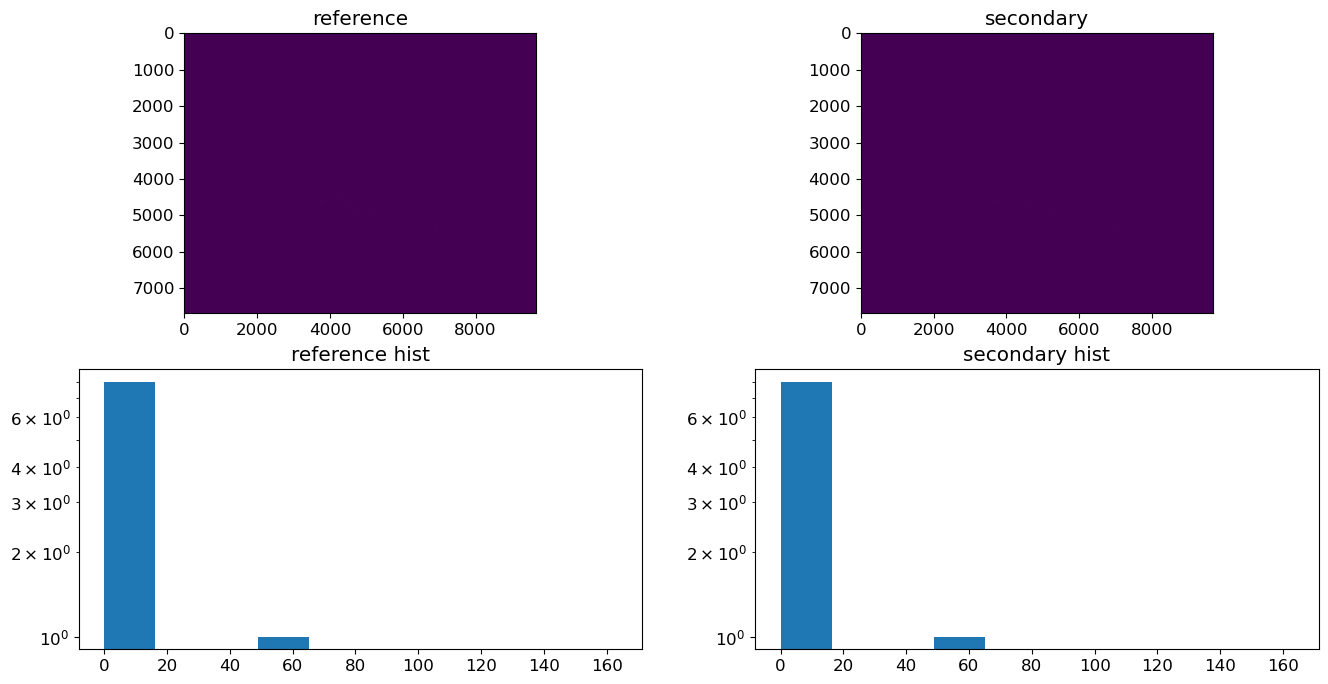

In [8]:
df_reference = convert_rast_to_df(reference)
df_secondary = convert_rast_to_df(secondary)

ref_counts, ref_bins = np.histogram(df_reference)
print(ref_counts)

sec_counts, sec_bins = np.histogram(df_secondary)
print(sec_counts)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, title="reference")
ax2 = fig.add_subplot(222, title="secondary")
ax3 = fig.add_subplot(223, title="reference hist")
ax4 = fig.add_subplot(224, title="secondary hist")

ax1.imshow(df_reference)
ax2.imshow(df_secondary)
ax3.hist(ref_counts, ref_bins, log=True)
ax4.hist(sec_counts, sec_bins, log=True)

### Flatten Reference and Secondary Scenes


In [9]:
with asfn.work_dir(f"{CWD}/work/"):
    
    df_reference_flatten = flatten_df(df_reference)
    filepath = "flat_reference.tif"   
    with rasterio.open(filepath, 'w', **reference.meta) as out:
        out.write(df_reference_flatten, 1)
        
    df_secondary_flatten = flatten_df(df_secondary)
    filepath = "flat_secondary.tif"
    with rasterio.open(filepath, "w", **secondary.meta) as out:
        out.write(df_secondary_flatten, 1)

### Plot Flatten Reference and Secondary Scenes

[33853368 22988357 10566827  2938765  1504199   955966   630155   425652
   294614   208353]
[33853368 22988357 10566827  2938765  1504199   955966   630155   425652
   294614   208353]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.04847306, 0.09694613, 0.1454192 , 0.19389226,
        0.24236532, 0.29083839, 0.33931145, 0.38778451, 0.43625757,
        0.48473063]),
 <BarContainer object of 10 artists>)

/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


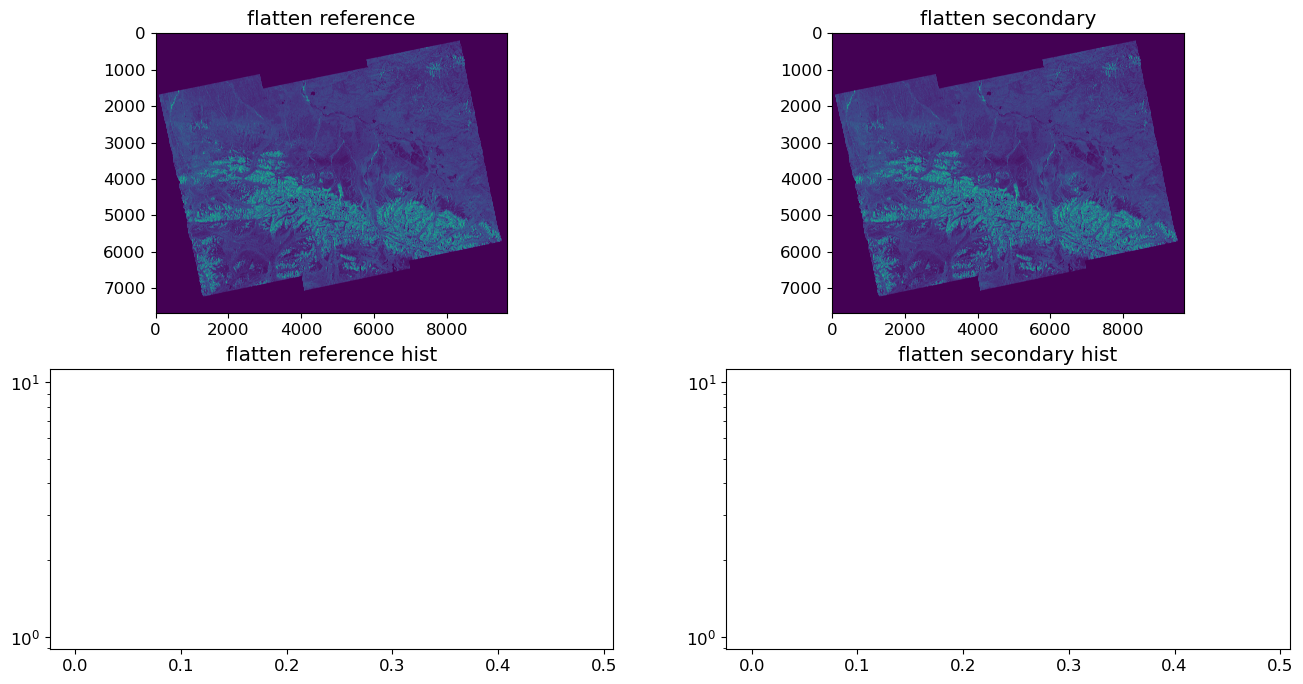

In [10]:
ref_counts, ref_bins = np.histogram(df_reference_flatten)
print(ref_counts)

sec_counts, sec_bins = np.histogram(df_secondary_flatten)
print(sec_counts)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, title="flatten reference")
ax2 = fig.add_subplot(222, title="flatten secondary")
ax3 = fig.add_subplot(223, title="flatten reference hist")
ax4 = fig.add_subplot(224, title="flatten secondary hist")

ax1.imshow(df_reference_flatten)
ax2.imshow(df_secondary_flatten)
ax3.hist(ref_counts, ref_bins, log=True)
ax4.hist(sec_counts, sec_bins, log=True)

### Find smallest common superset area and transform the scenes

In [11]:
ref_bound = reference.bounds
sec_bound = secondary.bounds

superset = {
    'left': min(ref_bound.left, sec_bound.left),
    'bottom': min(ref_bound.bottom, sec_bound.bottom), 
    'right': max(ref_bound.right, sec_bound.right), 
    'top': max(ref_bound.top, sec_bound.top)
}

print(ref_bound)
print(sec_bound)
print(superset)

with asfn.work_dir(f"{CWD}/work/"):
    gdal.Warp(
            str('flat_reference_superset.tif'), 
            str('flat_reference.tif'),
            outputBounds=(
                superset['left'], 
                superset['bottom'],
                superset['right'],
                superset['top'],
            ),
            outputBoundsSRS=reference.crs #"EPSG:4326"
        )
    
    gdal.Warp(
            str('flat_secondary_superset.tif'), 
            str('flat_secondary.tif'),
            outputBounds=(
                superset['left'], 
                superset['bottom'],
                superset['right'],
                superset['top'],
            ),
            outputBoundsSRS=secondary.crs #"EPSG:4326"
        )

BoundingBox(left=377520.0, bottom=6963780.0, right=667560.0, top=7194540.0)
BoundingBox(left=377520.0, bottom=6963780.0, right=667560.0, top=7194540.0)
{'left': 377520.0, 'bottom': 6963780.0, 'right': 667560.0, 'top': 7194540.0}


### Show superset-ed scenes

In [12]:
with asfn.work_dir(f"{CWD}/work/"):
    reference_superset = rasterio.open('flat_reference_superset.tif')    
    secondary_superset = rasterio.open('flat_secondary_superset.tif')

[31091437 14190611 15994395  6661011  2502740  1395810   955073   690975
   506789   377415]
[31091437 14190611 15994395  6661011  2502740  1395810   955073   690975
   506789   377415]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.03581833, 0.07163666, 0.107455  , 0.14327332,
        0.17909166, 0.21491   , 0.25072834, 0.28654665, 0.32236499,
        0.35818332]),
 <BarContainer object of 10 artists>)

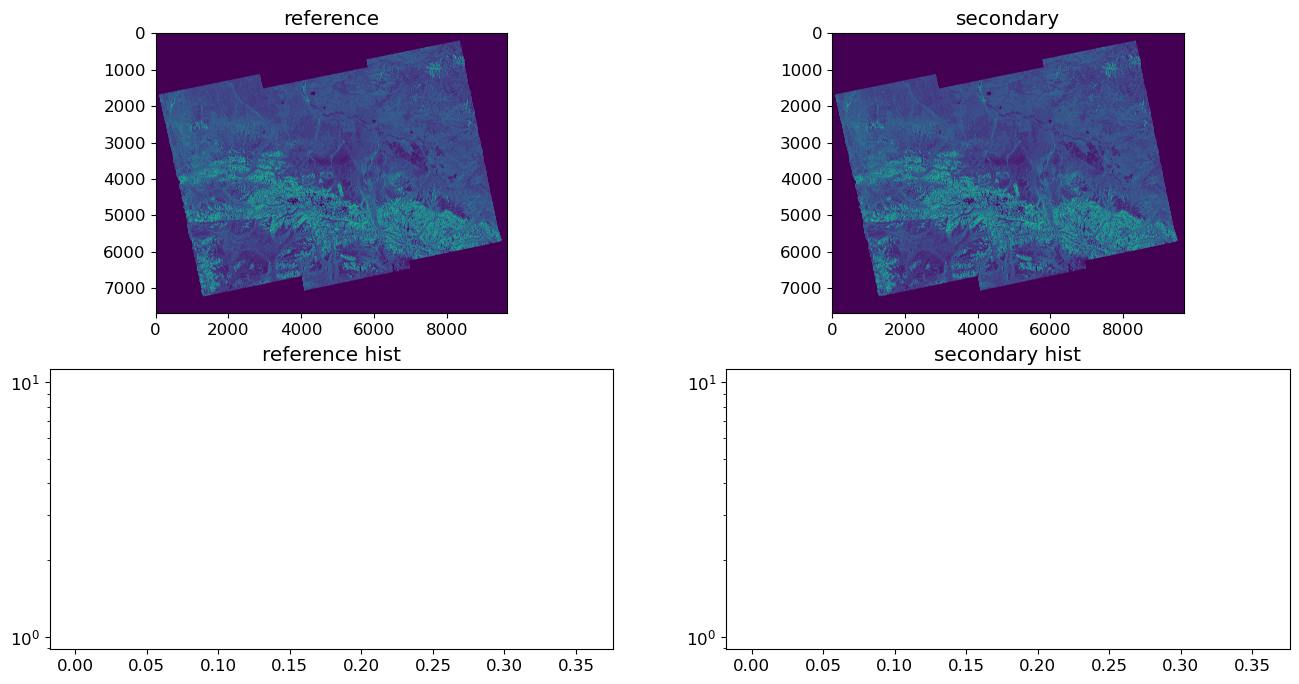

In [13]:
df_reference_superset = convert_rast_to_df(reference_superset)
df_reference_superset = flatten_df(df_reference_superset)

df_secondary_superset = convert_rast_to_df(secondary_superset)
df_secondary_superset = flatten_df(df_secondary_superset)


ref_counts, ref_bins = np.histogram(df_reference_superset)
print(ref_counts)

sec_counts, sec_bins = np.histogram(df_secondary_superset)
print(sec_counts)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, title="reference")
ax2 = fig.add_subplot(222, title="secondary")
ax3 = fig.add_subplot(223, title="reference hist")
ax4 = fig.add_subplot(224, title="secondary hist")

ax1.imshow(df_reference_superset)
ax2.imshow(df_secondary_superset)
ax3.hist(ref_counts, ref_bins, log=True)
ax4.hist(sec_counts, sec_bins, log=True)

### Perform cross-correlation on the tiffs (replacing Nans with Zeroes)

In [14]:
# Find cross correlation
# https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation

print("Phase Cross Correlation....")

shift, error, phase = phase_cross_correlation(
    df_reference_superset,
    df_secondary_superset,
    normalization=None
)

print(f"Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
print(f"Translation invariant normalized RMS error between reference_image and moving_image: {error}")
print(f"Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")

Phase Cross Correlation....
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Translation invariant normalized RMS error between reference_image and moving_image: 0.0012540163402131967
Global phase difference between the two images (should be zero if images are non-negative).: 1.3425707834358036e-07



### Tile scenes into equal rectangles/squares

//Save files as PNGs as well

In [15]:
# https://gis.stackexchange.com/a/306862
# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim
def splitImageIntoCells(img, filename, x_num=1, y_num=1):    
    x_dim = img.shape[1] // x_num
    y_dim = img.shape[0] // y_num

    x, y = 0, 0
    for y_iter in range(y_num):
        y = y_iter * y_dim
        for x_iter in range(x_num):
            x = x_iter * x_dim
            
            filepath = f'{filename}_{y_iter}_{x_iter}.tif'
            print(f"Creating tile {filepath}...")
            
            # Get tile geometry
            corner1 = img.transform * (x, y)
            corner2 = img.transform * (x + x_dim, y + y_dim)
            geom = geometry.box(corner1[0], corner1[1], corner2[0], corner2[1])
            
            # Get cell 
            crop, cropTransform = mask(img, [geom], crop=True)
            img.meta.update(
                {
                    "driver": "GTiff",
                    "height": crop.shape[1],
                    "width": crop.shape[2],
                    "transform": cropTransform,
                    "crs": img.crs
                }
            )
            
            with rasterio.open(filepath, "w", **img.meta) as out:
                out.write(crop)
                
            #rbg = PILImage.open(filepath).convert('RGB')
            #rbg.save(filepath + ".png")

In [16]:
start_time = datetime.now()
print(f"Start time is {start_time}\n")

!mkdir -p {CWD}/work/reference_tiles/
with asfn.work_dir(f"{CWD}/work/reference_tiles"):
    splitImageIntoCells(reference_superset, 'flat_reference', x_num=X_NUM, y_num=Y_NUM)
    
end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")

Start time is 2023-04-25 01:08:02.880801

Creating tile flat_reference_0_0.tif...
Creating tile flat_reference_0_1.tif...
Creating tile flat_reference_0_2.tif...
Creating tile flat_reference_0_3.tif...
Creating tile flat_reference_0_4.tif...
Creating tile flat_reference_0_5.tif...
Creating tile flat_reference_0_6.tif...
Creating tile flat_reference_0_7.tif...
Creating tile flat_reference_1_0.tif...
Creating tile flat_reference_1_1.tif...
Creating tile flat_reference_1_2.tif...
Creating tile flat_reference_1_3.tif...
Creating tile flat_reference_1_4.tif...
Creating tile flat_reference_1_5.tif...
Creating tile flat_reference_1_6.tif...
Creating tile flat_reference_1_7.tif...
Creating tile flat_reference_2_0.tif...
Creating tile flat_reference_2_1.tif...
Creating tile flat_reference_2_2.tif...
Creating tile flat_reference_2_3.tif...
Creating tile flat_reference_2_4.tif...
Creating tile flat_reference_2_5.tif...
Creating tile flat_reference_2_6.tif...
Creating tile flat_reference_2_7.tif..

In [17]:
start_time = datetime.now()
print(f"Start time is {start_time}\n")

!mkdir -p {CWD}/work/secondary_tiles/
with asfn.work_dir(f"{CWD}/work/secondary_tiles"):
    splitImageIntoCells(secondary_superset, 'flat_secondary', x_num=X_NUM, y_num=Y_NUM)
    
end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")

Start time is 2023-04-25 01:09:02.899238

Creating tile flat_secondary_0_0.tif...
Creating tile flat_secondary_0_1.tif...
Creating tile flat_secondary_0_2.tif...
Creating tile flat_secondary_0_3.tif...
Creating tile flat_secondary_0_4.tif...
Creating tile flat_secondary_0_5.tif...
Creating tile flat_secondary_0_6.tif...
Creating tile flat_secondary_0_7.tif...
Creating tile flat_secondary_1_0.tif...
Creating tile flat_secondary_1_1.tif...
Creating tile flat_secondary_1_2.tif...
Creating tile flat_secondary_1_3.tif...
Creating tile flat_secondary_1_4.tif...
Creating tile flat_secondary_1_5.tif...
Creating tile flat_secondary_1_6.tif...
Creating tile flat_secondary_1_7.tif...
Creating tile flat_secondary_2_0.tif...
Creating tile flat_secondary_2_1.tif...
Creating tile flat_secondary_2_2.tif...
Creating tile flat_secondary_2_3.tif...
Creating tile flat_secondary_2_4.tif...
Creating tile flat_secondary_2_5.tif...
Creating tile flat_secondary_2_6.tif...
Creating tile flat_secondary_2_7.tif..

### Using Dask parallelization, calculate the cross correlation of the tiles

In [18]:
RAM_PER_WORKER_GB = 20
NUM_WORKERS = 6
NUM_THREADS_PER_WORKER = 1

cluster = dask.distributed.LocalCluster(
    threads_per_worker=NUM_THREADS_PER_WORKER,
    n_workers=NUM_WORKERS,
    memory_limit=f"{RAM_PER_WORKER_GB}GB",
    processes=True
)

client = dask.distributed.Client(cluster)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 111.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45173,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 111.76 GiB
Comm: tcp://127.0.0.1:43161,Total threads: 1
Dashboard: http://127.0.0.1:33293/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:35105,


In [19]:
def calc_data(args):
    
        count = args['count']
        ref_file_path = args['ref_file_path']
        sec_file_path = args['sec_file_path']
        
        ###### Reference 
        stime = datetime.now()
        print(f"\nTile {count}: Rendering {ref_file_path}...")
        rast = rasterio.open(ref_file_path)
        
        df_ref = convert_rast_to_df(rast)
        #df_ref = flatten_df(df_ref)
        print(f"Tile {count}: Time to complete ref: {datetime.now() - stime}")

        
        ###### Secondary
        stime = datetime.now()
        print(f"\nTile {count}: Rendering {sec_file_path}...")
        rast = rasterio.open(sec_file_path)
        
        df_sec = convert_rast_to_df(rast)
        #df_sec = flatten_df(df_sec)
        print(f"Tile {count}: Time to complete sec: {datetime.now() - stime}")
    
    
        ####### Cross corr without masking
        stime = datetime.now()
        print(f"\nTile {count}: Finding phase correlation with nans set to zero....")
        shift, error, phase = phase_cross_correlation(
            
            df_ref.replace(np.nan, 0), 
            df_sec.replace(np.nan, 0),
            
            normalization=None
        )
        print(f"Tile {count}: Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
        print(f"Tile {count}: Translation invariant normalized RMS error between reference_image and moving_image: {error}")
        print(f"Tile {count}: Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")

        print(f"Tile {count}:  Time to complete correlation: {datetime.now() - stime}")
        
        return {
            "count": count,
            "ref_file": ref_file_path,
            "sec_file": sec_file_path,
            "shift": shift, 
            "error": error, 
            "phase": phase
        }

def get_cross_corr_args() -> list:
    
    cross_corr_args = []

    count = 1
    for i in range(X_NUM):

        #if i not in [5,6]:
        #    continue

        for j in range(Y_NUM):

            #if j not in [5,6]:
            #    continue

            cross_corr_args.append({
                'count': count,
                'ref_file_path': f'{CWD}/work/reference_tiles/flat_reference_{i}_{j}.tif',
                'sec_file_path': f'{CWD}/work/secondary_tiles/flat_secondary_{i}_{j}.tif'
            })

            count = count + 1
            
    return cross_corr_args
    
def do_dask(cross_corr_args: list) -> list:
    futures = client.map(calc_data, cross_corr_args)
    dask.distributed.progress(futures)
    
    return client.gather(futures)

In [20]:
start_time = datetime.now()
print(f"Global start time is {start_time}\n")

cross_corr_args = get_cross_corr_args()
cross_corr_results = do_dask(cross_corr_args)

client.shutdown()

end_time = datetime.now()
print(f"\nGlobal end time is {end_time}")
print(f"\nGlobal time elapsed is {end_time - start_time}")

Global start time is 2023-04-25 01:11:11.554604



/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in divide
  error = 1.0 - cross_correlation_max * cross_correlation_ma


Tile 6: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference_tiles/flat_reference_0_5.tif...
Tile 6: Time to complete ref: 0:00:00.309253

Tile 6: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/secondary_tiles/flat_secondary_0_5.tif...
Tile 6: Time to complete sec: 0:00:00.195684

Tile 6: Finding phase correlation with nans set to zero....
Tile 6: Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Tile 6: Translation invariant normalized RMS error between reference_image and moving_image: 0.000418697658751736
Tile 6: Global phase difference between the two images (should be zero if images are non-negative).: 5.778979073056689e-08

Tile 6:  Time to complete correlation: 0:00:18.794090

Tile 12: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference_tiles/flat_reference_1_3.tif...
Tile 12: Time to complete ref: 0:00:00.

/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\


Tile 57: Global phase difference between the two images (should be zero if images are non-negative).: -2.4205742965577315e-10

Tile 57:  Time to complete correlation: 0:00:19.429629

Tile 63: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference_tiles/flat_reference_7_6.tif...
Tile 63: Time to complete ref: 0:00:00.185771

Tile 63: Rendering /home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/secondary_tiles/flat_secondary_7_6.tif...
Tile 63: Time to complete sec: 0:00:00.189339

Tile 63: Finding phase correlation with nans set to zero....
Tile 63: Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Tile 63: Translation invariant normalized RMS error between reference_image and moving_image: nan
Tile 63: Global phase difference between the two images (should be zero if images are non-negative).: 0.0

Tile 63:  Time to complete correlation: 0:00:17.907748
Tile 56: Global phase di

### Print results

In [21]:
pprint(cross_corr_results)

[{'count': 1,
  'error': nan,
  'phase': 0.0,
  'ref_file': '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference_tiles/flat_reference_0_0.tif',
  'sec_file': '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/secondary_tiles/flat_secondary_0_0.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'count': 2,
  'error': nan,
  'phase': 0.0,
  'ref_file': '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference_tiles/flat_reference_0_1.tif',
  'sec_file': '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/secondary_tiles/flat_secondary_0_1.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'count': 3,
  'error': nan,
  'phase': 0.0,
  'ref_file': '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/reference_tiles/flat_reference_0_2.tif',
  'sec_file': '/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/work/secon

### Plot Reference tiles, Secondary tiles and Correlation tiles

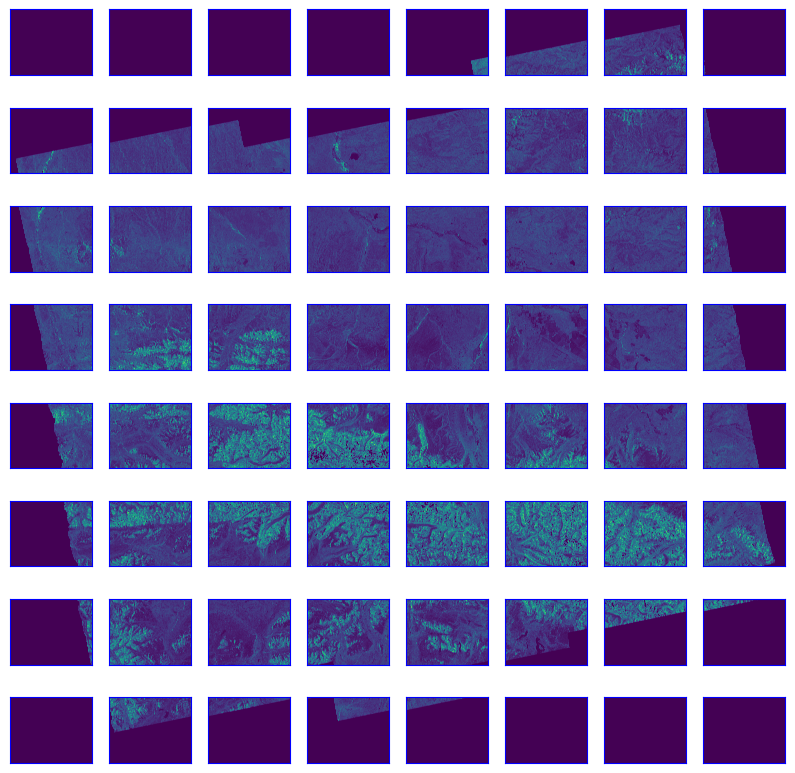

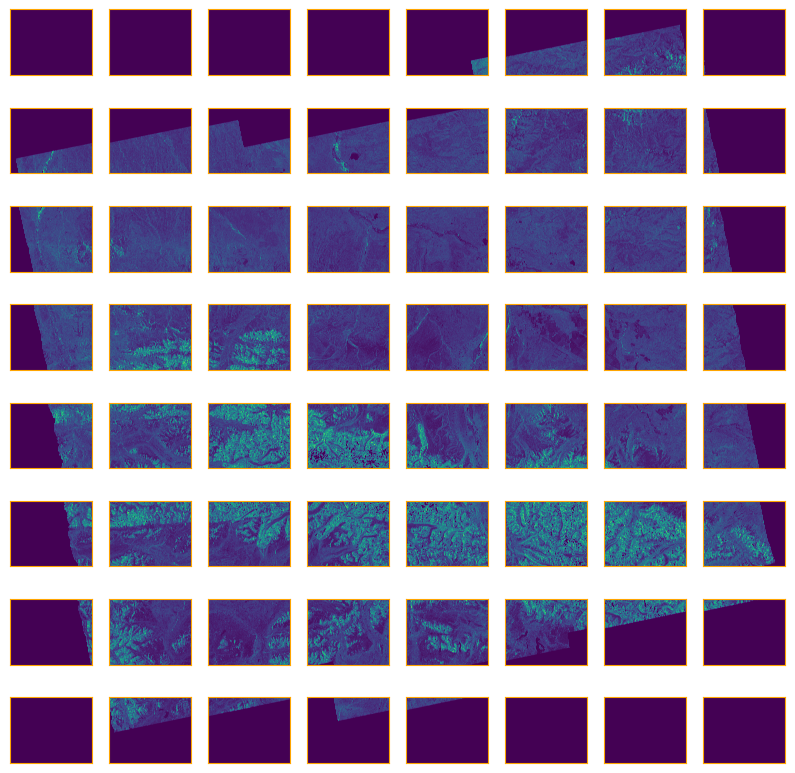

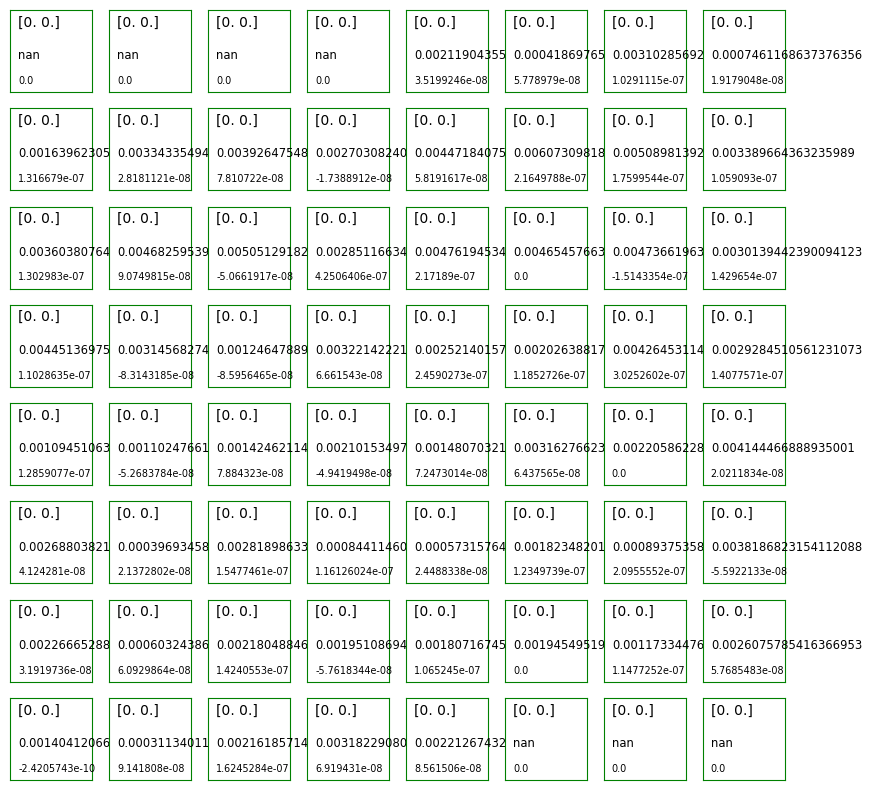

In [22]:
ref_plt = plt.figure(figsize=(10,10))
sec_plt = plt.figure(figsize=(10,10))
corr_plt = plt.figure(figsize=(10,10))        
    
for cross_corr_result in cross_corr_results:
    
    count = cross_corr_result['count']
    ref_file_path = cross_corr_result['ref_file']
    sec_file_path = cross_corr_result['sec_file']
    shift = cross_corr_result['shift']
    error = cross_corr_result['error']
    phase = cross_corr_result['phase']
    
    # Plot references
    rast = rasterio.open(ref_file_path)
    df_ref = convert_rast_to_df(rast)
    
    ax_ref = ref_plt.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
    ax_ref.spines[:].set_color('blue')
    ax_ref.imshow(df_ref)
    
    # Plot secondary
    rast = rasterio.open(sec_file_path)
    df_sec = convert_rast_to_df(rast)
    
    ax_sec = sec_plt.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
    ax_sec.spines[:].set_color('orange')
    ax_sec.imshow(df_sec)
    
    # Plot result texts
    ax_corr = corr_plt.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
    ax_corr.spines[:].set_color('green')
    ax_corr.text(0.1, 0.8, str(shift), transform = ax_corr.transAxes, fontsize='small')
    ax_corr.text(0.1, 0.4, str(error), transform = ax_corr.transAxes, fontsize='x-small')
    ax_corr.text(0.1, 0.1, str(phase), transform = ax_corr.transAxes, fontsize='xx-small')

### Graph some of the results

In [23]:
df_cross_corr_results = pd.DataFrame(cross_corr_results)

# Split out shift into x and y
df_cross_corr_results['xshift'] = df_cross_corr_results.apply(lambda x: x['shift'][0], axis=1)
df_cross_corr_results['yshift'] = df_cross_corr_results.apply(lambda x: x['shift'][1], axis=1)

# Create shift perimeter
df_cross_corr_results['shift_perimeter'] = df_cross_corr_results.apply(lambda x: np.sqrt(x['shift'][0]**2 + x['shift'][1]**2), axis=1)

df_cross_corr_results

,count,ref_file,sec_file,shift,error,phase,xshift,yshift,shift_perimeter
0,1,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",NaN,0.000000e+00,0.0,0.0,0.0
1,2,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",NaN,0.000000e+00,0.0,0.0,0.0
2,3,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",NaN,0.000000e+00,0.0,0.0,0.0
3,4,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",NaN,0.000000e+00,0.0,0.0,0.0
4,5,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",0.002119,3.519925e-08,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
59,60,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",0.003182,6.919431e-08,0.0,0.0,0.0
60,61,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",0.002213,8.561506e-08,0.0,0.0,0.0
61,62,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",NaN,0.000000e+00,0.0,0.0,0.0
62,63,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,"[0.0, 0.0]",NaN,0.000000e+00,0.0,0.0,0.0


<Axes: xlabel='shift_perimeter', ylabel='error'>

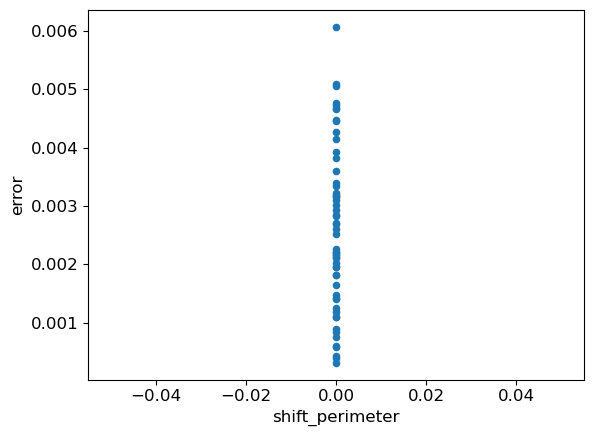

In [24]:
df_cross_corr_results.plot.scatter(x = 'shift_perimeter', y = 'error')

<Axes: xlabel='xshift', ylabel='yshift'>

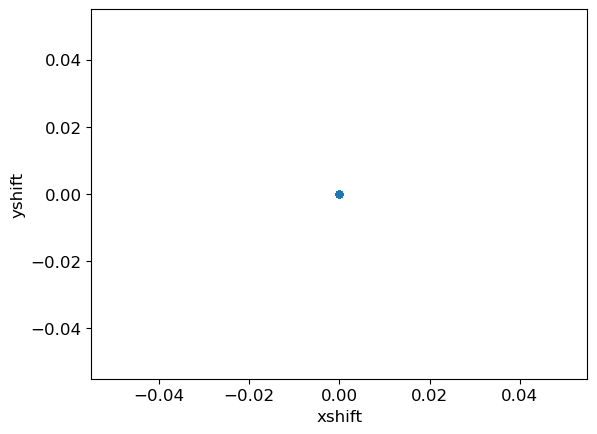

In [25]:
df_cross_corr_results.plot.scatter(x = 'xshift', y = 'yshift')